In [2]:
import scipy.stats as sps
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from graphviz import Digraph

from statsmodels.stats.proportion import proportion_confint
from statsmodels.formula.api import ols

from catboost import CatBoostRegressor
from joblib import Parallel, delayed

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1, palette="Set2")

# Анализ пользовательской активности на образовательном портале Teach-in.ru

## Описание проекта
Анализ данных о визитах пользователей на сайте Teach-in.ru — образовательной платформе, посвященной дополнительному образованию и курсам повышения квалификации. Данные охватывают период с 2020 года.

**Определение визита:** Визит — это последовательность действий пользователя на сайте, которая начинается на некоторой странице сайта, содержит в себе переходы по ссылкам (просмотр курсов, изучение программ, регистрация) и другие действия, и заканчивается на какой-то, возможно, другой страницей сайта. Визит считается завершенным, если активность отсутствует в течение 30 минут.

## Задачи анализа
1. Сколько всего визитов представлено в данных?
2. Когда совершены первый и последний визиты?
3. Постройте динамику количества визитов во времени по дням
4. Сколько уникальных пользователей в данных?
5. Сколько в среднем один пользователь совершил визитов? Сколько максимально?
6. Постройте гистограмму глубины и продолжительности визитов
7. Из каких стран больше пользователей?
8. Какие браузеры и операционные системы в топе?

___

Считаем данные

In [3]:
data = pd.read_csv("data.tsv", sep="\t")
data.head()

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserCountry,mobilePhone,operatingSystemRoot,browser,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight
0,1.801686e+19,1568056026568729022,2020-12-31 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,gb,NaN,gnu_linux,chrome,WebKit,2,1920,1080,1905,981
1,1.802359e+19,1577864187752491163,2020-12-31 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,Singapore,...,us,apple,ios_double,safari_mobile,WebKit,1,375,667,375,559
2,1.802460e+19,1567765219104836417,2020-12-31 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,ru,apple,ios_double,yandex_browser,WebKit,1,414,736,414,660
3,1.802475e+19,1576839432510419026,2020-12-31 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,China,...,ru,samsung,android,chromemobile,WebKit,1,412,892,412,756
4,1.802518e+19,1576246599115183097,2020-12-31 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,ru,NaN,gnu_linux,firefox,Gecko,2,1920,1080,913,942


Изменим тип на дату.

In [4]:
data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])

## 1. Исследование данных

Решим пункты 1, 2, 4, 5.

In [5]:
visits_per_user = data.groupby('clientID').size()
print(f"""
Количество визитов: {len(data):,}
Первый визит: {data["dateTimeUTC"].min().strftime("%Y-%m-%d")}
Последний визит: {data["dateTimeUTC"].max().strftime("%Y-%m-%d")}
Уникальных пользователей: {data["clientID"].nunique():,}
В среднем визитов на пользователя: {visits_per_user.mean():.1f}
Максимум визитов: {visits_per_user.max()}
""")


Количество визитов: 387,353
Первый визит: 2020-12-31
Последний визит: 2025-02-24
Уникальных пользователей: 162,474
В среднем визитов на пользователя: 2.4
Максимум визитов: 58700



Разобьем время посещение на дату и на час, а также выделим год и месяц

In [22]:
data["hour"] = data["dateTimeUTC"].dt.hour
data["date"] = pd.to_datetime(data["dateTimeUTC"].dt.date)
data["year"] = data["date"].apply(lambda dt: dt.year)
data["month"] = data["date"].apply(lambda dt: dt.month)
data = data[data['dateTimeUTC'] >= '2021-01-01']
data

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight,hour,date,year,month,siteType
16,1.803658e+19,1577913752716130576,2021-01-01 00:22:34,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,15,1,0,other,...,2,1366,768,1349,608,0,2021-01-01,2021,1,1
17,1.803668e+19,1568056026568729022,2021-01-01 00:28:51,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,17,0,0,Russia,...,2,1920,1080,1905,981,0,2021-01-01,2021,1,1
18,1.803746e+19,1567465093162705334,2021-01-01 01:18:24,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,0,0,1,Russia,...,1,375,667,375,551,1,2021-01-01,2021,1,1
19,1.803809e+19,1566646596524658728,2021-01-01 01:58:15,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,16,0,0,Russia,...,2,1920,1080,1905,938,1,2021-01-01,2021,1,1
20,1.804237e+19,1577935847578546290,2021-01-01 06:30:47,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/index.html,2,2,1,0,other,...,2,1366,768,1351,768,6,2021-01-01,2021,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387348,8.349148e+17,170889374781031580,2025-02-24 23:42:27,https://miptstats.github.io/,https://miptstats.github.io/,1,15,1,0,Russia,...,1,384,832,384,756,23,2025-02-24,2025,2,0
387349,8.349555e+17,1706366044539443064,2025-02-24 23:45:02,https://miptstats.github.io/courses/python/09_...,https://miptstats.github.io/courses/python/09_...,1,0,0,1,Russia,...,2,1600,900,1583,771,23,2025-02-24,2025,2,0
387350,8.350287e+17,1707574597556843446,2025-02-24 23:49:41,https://miptstats.github.io/courses/ad_fivt/ta...,https://miptstats.github.io/courses/ad_fivt/ta...,1,0,0,1,Russia,...,2,1536,864,1519,729,23,2025-02-24,2025,2,0
387351,8.350809e+17,17088943799001288,2025-02-24 23:52:59,https://mipt-stats.gitlab.io/courses/python/05...,https://mipt-stats.gitlab.io/courses/python/05...,1,23,1,0,Russia,...,1,393,851,393,687,23,2025-02-24,2025,2,1


#### Количество визитов по часам

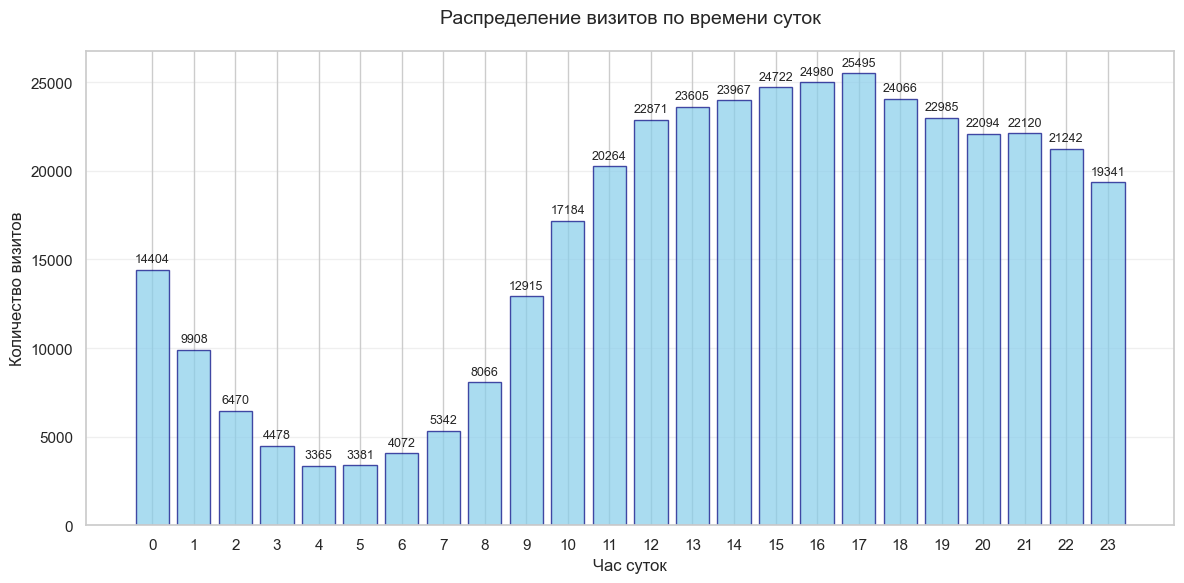

In [7]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(12, 6))
    
    
    hours_count = data["hour"].astype(int).value_counts().sort_index()
    
    bars = plt.bar(hours_count.index, hours_count.values, 
                   color='skyblue', edgecolor='navy', alpha=0.7)
    
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(hours_count.values)*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.xlabel("Час суток", fontsize=12)
    plt.ylabel("Количество визитов", fontsize=12)
    plt.title("Распределение визитов по времени суток", fontsize=14, pad=20)
    plt.xticks(range(24))
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### Динамика количества визитов во времени по дням

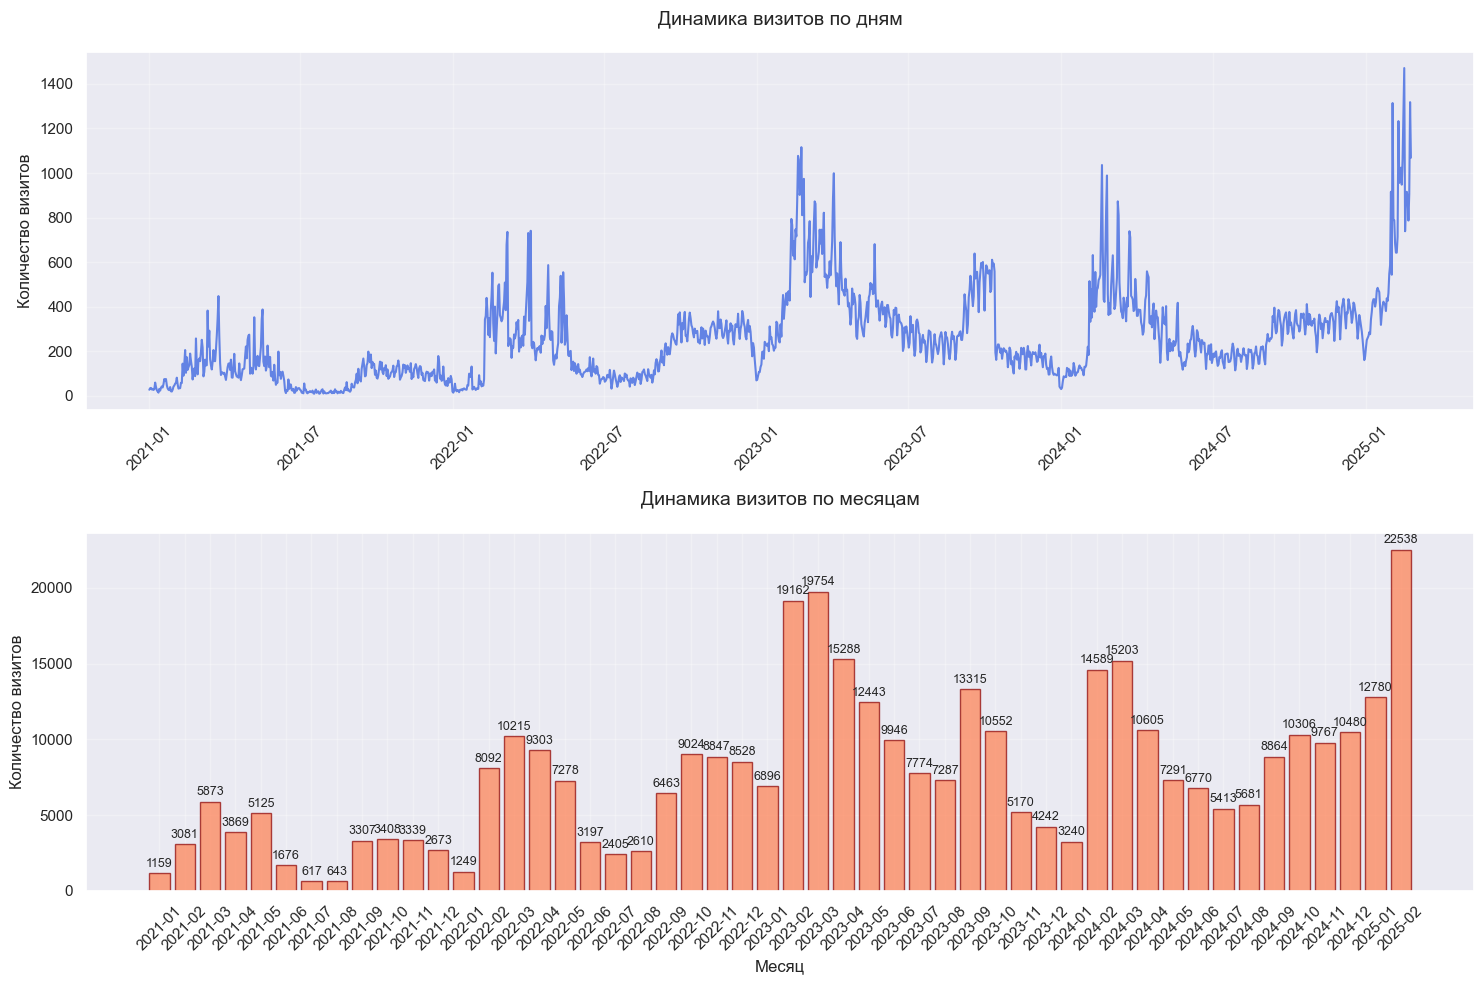

In [8]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    
    daily_visits = data.groupby("date")["clientID"].count()
    ax1.plot(daily_visits.index, daily_visits.values, 
             linewidth=1.5, color='royalblue', alpha=0.8)
    ax1.set_ylabel("Количество визитов", fontsize=12)
    ax1.set_title("Динамика визитов по дням", fontsize=14, pad=20)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    
    data['month'] = data['date'].dt.to_period('M').astype(str)
    monthly_visits = data.groupby("month")["clientID"].count()
    
    ax2.bar(monthly_visits.index, monthly_visits.values, 
            color='coral', alpha=0.7, edgecolor='darkred')
    ax2.set_ylabel("Количество визитов", fontsize=12)
    ax2.set_xlabel("Месяц", fontsize=12)
    ax2.set_title("Динамика визитов по месяцам", fontsize=14, pad=20)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    
    for i, value in enumerate(monthly_visits.values):
        ax2.text(i, value + max(monthly_visits.values)*0.01, 
                f'{int(value)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

Можем наблюдать наличие пиков-выбросов во временных периодах

####  Глубина и длительность просмотров

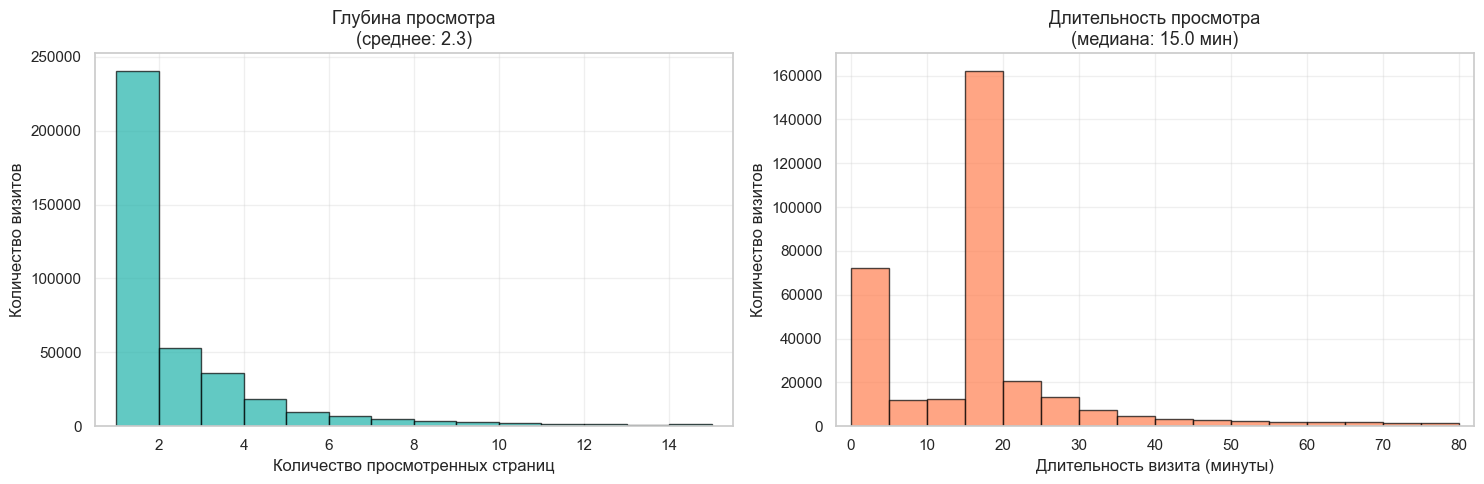

In [9]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    
    axes[0].hist(data["pageViews"], bins=np.arange(1, 16), 
                 color='lightseagreen', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel("Количество просмотренных страниц", fontsize=12)
    axes[0].set_ylabel("Количество визитов", fontsize=12)
    axes[0].set_title(f"Глубина просмотра\n(среднее: {data['pageViews'].mean():.1f})", fontsize=13)
    axes[0].set_xlim(0.5, 15.5)
    axes[0].grid(True, alpha=0.3)
    
    
    axes[1].hist(data["visitDuration"], bins=np.arange(0, 85, 5), 
                 color='coral', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel("Длительность визита (минуты)", fontsize=12)
    axes[1].set_ylabel("Количество визитов", fontsize=12)
    axes[1].set_title(f"Длительность просмотра\n(медиана: {data['visitDuration'].median():.1f} мин)", fontsize=13)
    axes[1].set_xlim(-2, 82)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Есть явно выбросные значения. Странно, что длительность просмотра часто находится в пределах 15-20, но в бинах рядом значения принимаются сильно реже.

#### Топ браузеров

Cразу же будем заменять редко встречающиеся значения на `other`.

Топ-10 самых популярных браузеров (без объединения)


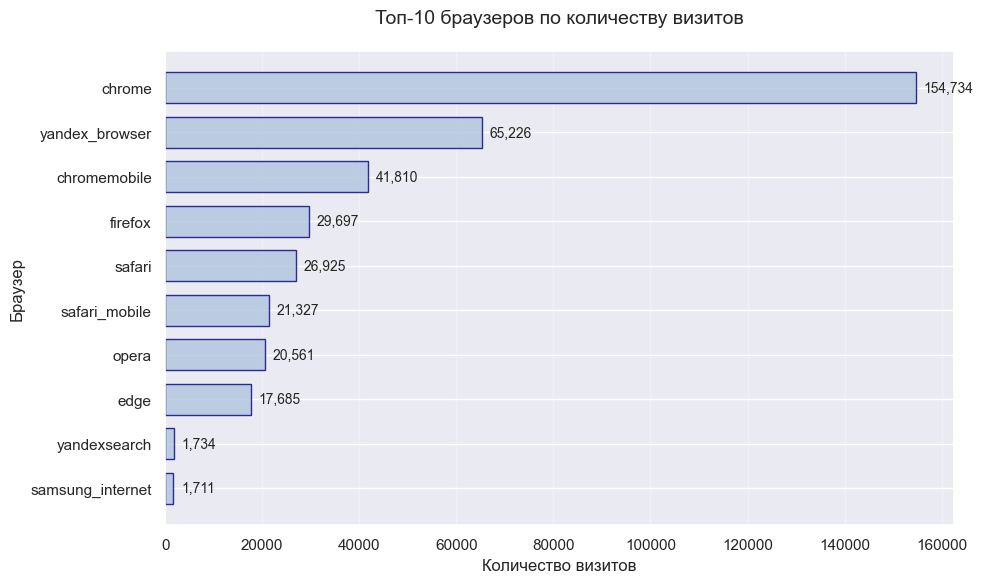

In [10]:

print("Топ-10 самых популярных браузеров (без объединения)")

data["browser"] = data["browser"].astype(str)
browser_counts = (
    data.groupby(by="browser")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
top_10_browsers = browser_counts.head(10)


bars = plt.barh(range(len(top_10_browsers)), top_10_browsers.values, 
                color='lightsteelblue', edgecolor='navy', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Браузер", fontsize=12)
plt.title("Топ-10 браузеров по количеству визитов", fontsize=14, pad=20)
plt.yticks(range(len(top_10_browsers)), top_10_browsers.index)
plt.grid(axis='x', alpha=0.3)


for i, (browser, count) in enumerate(top_10_browsers.items()):
    plt.text(count + max(top_10_browsers.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

Топ браузеров с объединением редких в 'other'


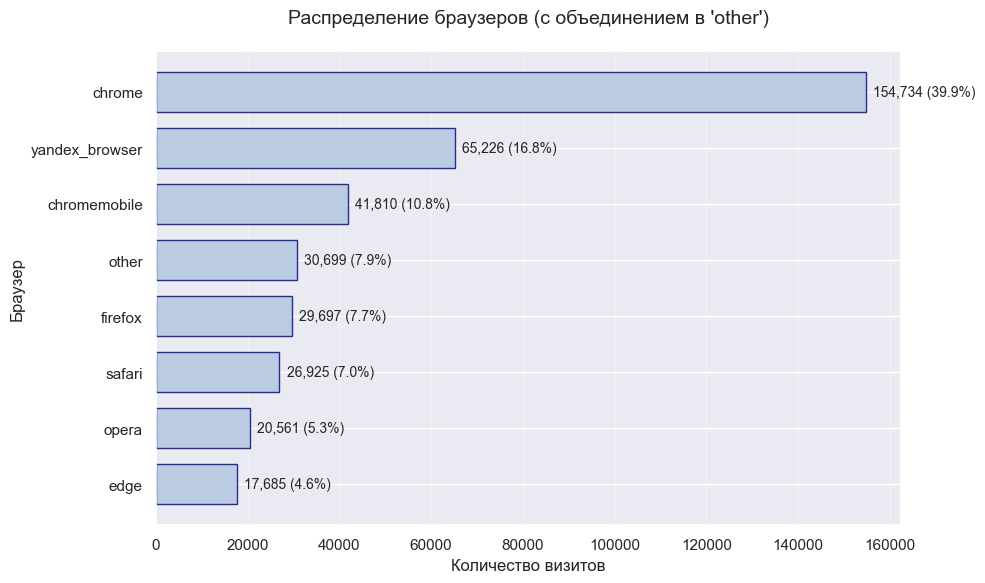

In [11]:

print("Топ браузеров с объединением редких в 'other'")

browsers = [
    "chrome",
    "yandex_browser", 
    "chromemobile",
    "firefox",
    "safari",
    "opera",
    "edge",
]

data.loc[~data["browser"].isin(browsers), "browser"] = "other"

browser_counts_merged = (
    data.groupby(by="browser")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(browser_counts_merged)), browser_counts_merged.values,
                color='lightsteelblue', edgecolor='navy', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Браузер", fontsize=12)
plt.title("Распределение браузеров (с объединением в 'other')", fontsize=14, pad=20)
plt.yticks(range(len(browser_counts_merged)), browser_counts_merged.index)
plt.grid(axis='x', alpha=0.3)

total_visits = len(data)
for i, (browser, count) in enumerate(browser_counts_merged.items()):
    percentage = (count / total_visits) * 100
    plt.text(count + max(browser_counts_merged.values)*0.01, i,
             f'{int(count):,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Топ по странам

Топ-10 стран по количеству визитов


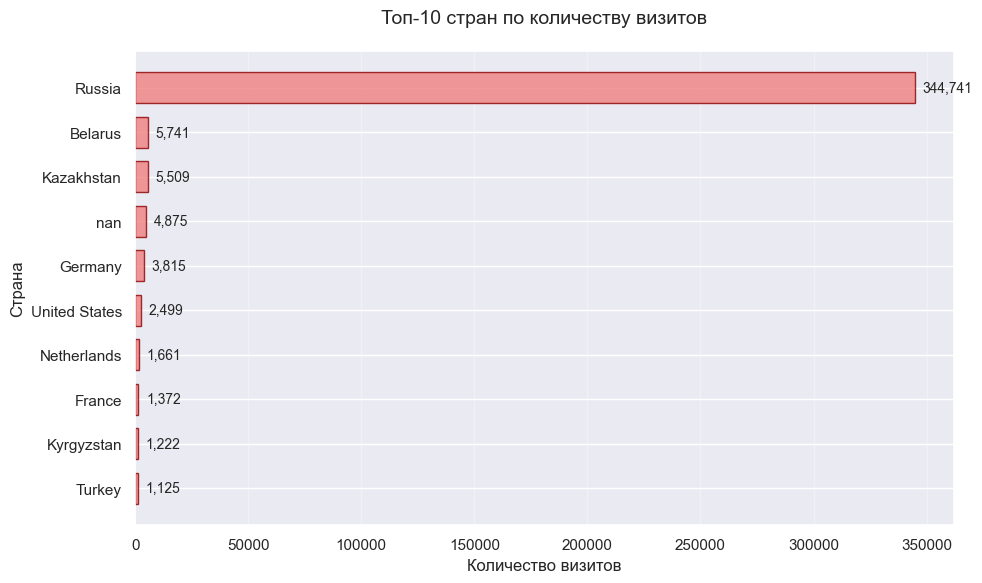

In [12]:

print("Топ-10 стран по количеству визитов")

data["regionCountry"] = data["regionCountry"].astype(str)
country_counts = (
    data.groupby(by="regionCountry")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
top_10_countries = country_counts.head(10)

bars = plt.barh(range(len(top_10_countries)), top_10_countries.values, 
                color='lightcoral', edgecolor='darkred', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Страна", fontsize=12)
plt.title("Топ-10 стран по количеству визитов", fontsize=14, pad=20)
plt.yticks(range(len(top_10_countries)), top_10_countries.index)
plt.grid(axis='x', alpha=0.3)

for i, (country, count) in enumerate(top_10_countries.items()):
    plt.text(count + max(top_10_countries.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Распределение визитов: Россия vs другие страны


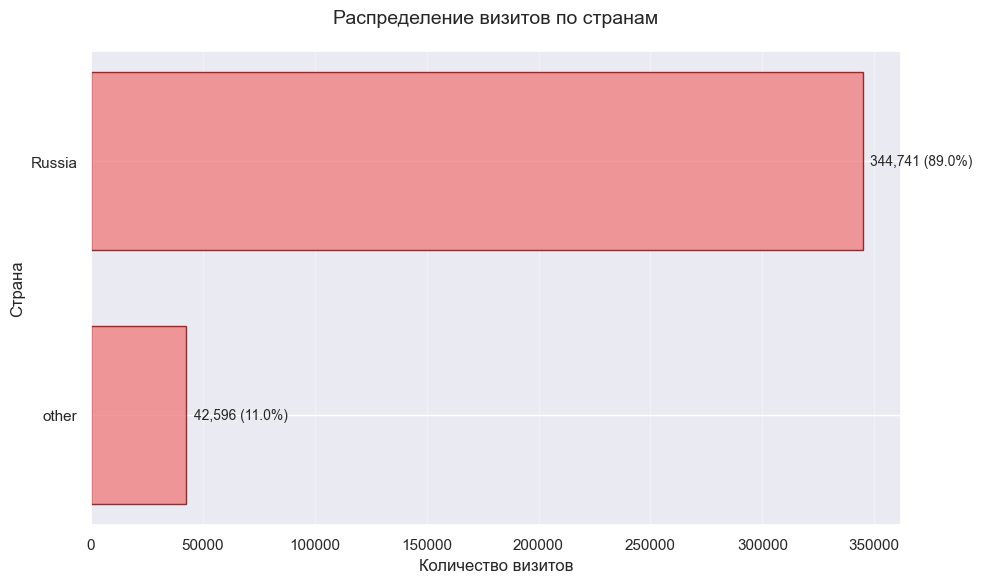

In [13]:
print("Распределение визитов: Россия vs другие страны")

data.loc[data["regionCountry"] != "Russia", "regionCountry"] = "other"

country_counts_merged = (
    data.groupby(by="regionCountry")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(country_counts_merged)), country_counts_merged.values,
                color='lightcoral', edgecolor='darkred', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Страна", fontsize=12)
plt.title("Распределение визитов по странам", fontsize=14, pad=20)
plt.yticks(range(len(country_counts_merged)), country_counts_merged.index)
plt.grid(axis='x', alpha=0.3)

total_visits = len(data)
for i, (country, count) in enumerate(country_counts_merged.items()):
    percentage = (count / total_visits) * 100
    plt.text(count + max(country_counts_merged.values)*0.01, i,
             f'{int(count):,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Топ по ОС

Самые популярные ОС


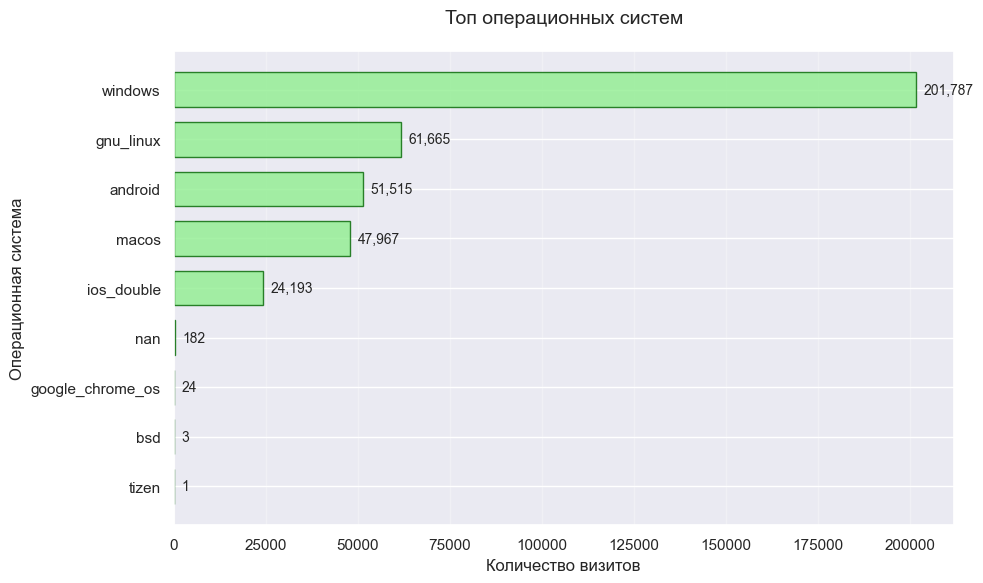

In [14]:
print("Самые популярные ОС")
data["operatingSystemRoot"] = data["operatingSystemRoot"].astype(str)
os_counts = (
    data.groupby(by="operatingSystemRoot")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
top_os = os_counts.head(10)

bars = plt.barh(range(len(top_os)), top_os.values, 
                color='lightgreen', edgecolor='darkgreen', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Операционная система", fontsize=12)
plt.title("Топ операционных систем", fontsize=14, pad=20)
plt.yticks(range(len(top_os)), top_os.index)
plt.grid(axis='x', alpha=0.3)

for i, (os_name, count) in enumerate(top_os.items()):
    plt.text(count + max(top_os.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Самые популярные ОС без лишнего шума


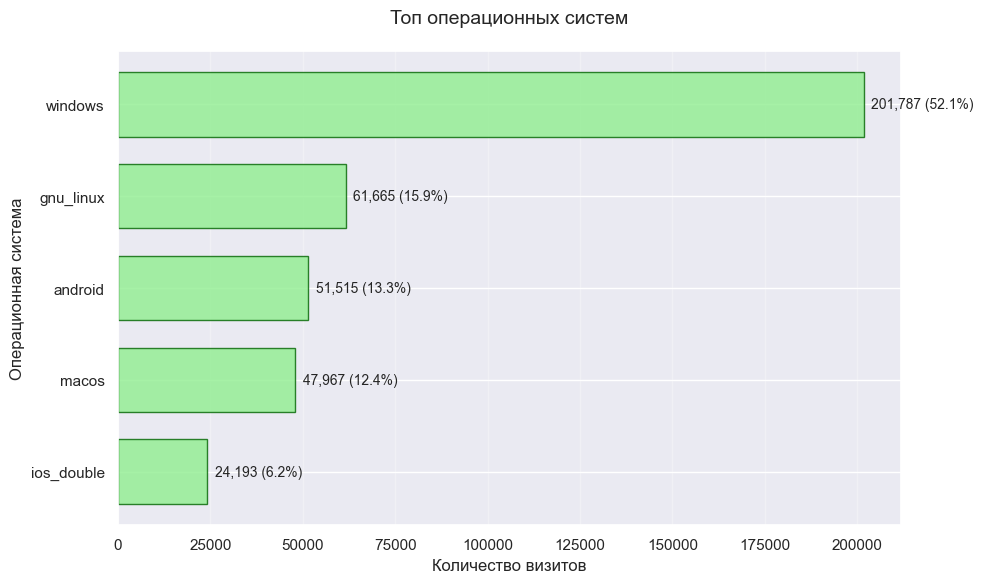

In [15]:
print("Самые популярные ОС без лишнего шума")
os_list = ["windows", "gnu_linux", "android", "macos", "ios_double"]
data = data[data["operatingSystemRoot"].isin(os_list)]

os_counts_merged = (
    data.groupby(by="operatingSystemRoot")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(os_counts_merged)), os_counts_merged.values,
                color='lightgreen', edgecolor='darkgreen', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Операционная система", fontsize=12)
plt.title("Топ операционных систем", fontsize=14, pad=20)
plt.yticks(range(len(os_counts_merged)), os_counts_merged.index)
plt.grid(axis='x', alpha=0.3)

total_visits = len(data)
for i, (os_name, count) in enumerate(os_counts_merged.items()):
    percentage = (count / total_visits) * 100
    plt.text(count + max(os_counts_merged.values)*0.01, i,
             f'{int(count):,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Ориентации экрана

Самые популярные ориентации экрана


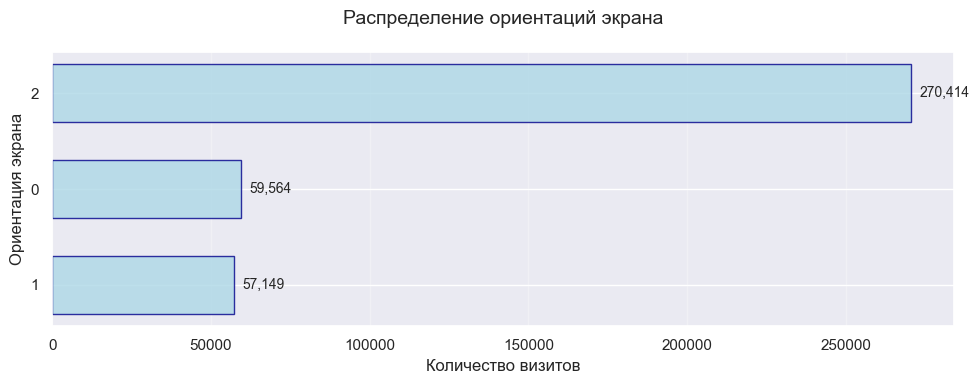

In [16]:
print("Самые популярные ориентации экрана")
orientation_counts = (
    data.groupby(by="screenOrientation")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 4))
bars = plt.barh(range(len(orientation_counts)), orientation_counts.values,
                color='lightblue', edgecolor='darkblue', alpha=0.8, height=0.6)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Ориентация экрана", fontsize=12)
plt.title("Распределение ориентаций экрана", fontsize=14, pad=20)
plt.yticks(range(len(orientation_counts)), orientation_counts.index)
plt.grid(axis='x', alpha=0.3)

for i, (orientation, count) in enumerate(orientation_counts.items()):
    plt.text(count + max(orientation_counts.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Типы интернет-сетей

Самые популярные типы сетей


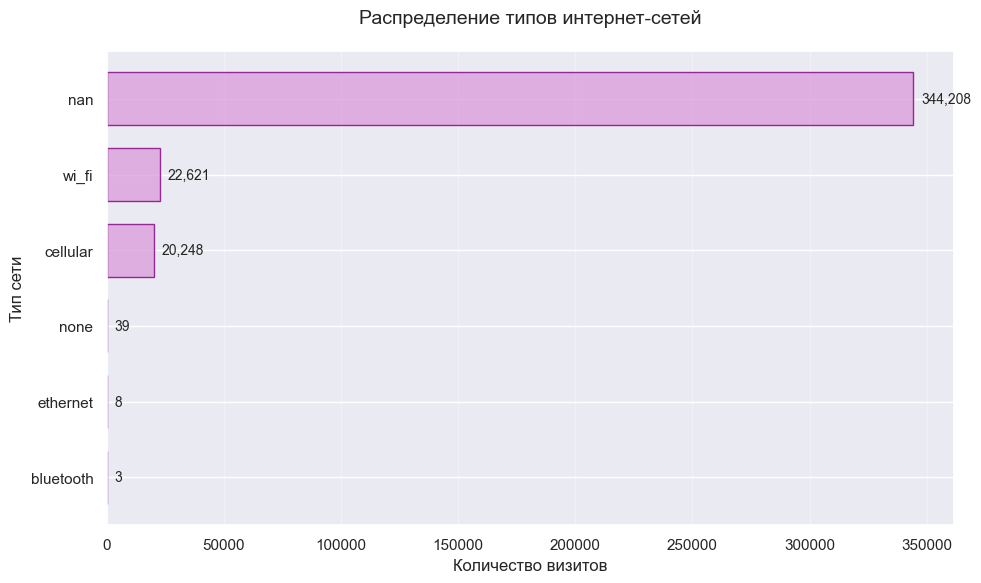

In [17]:
print("Самые популярные типы сетей")
data["networkType"] = data["networkType"].astype(str)
network_counts = (
    data.groupby(by="networkType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(network_counts)), network_counts.values,
                color='plum', edgecolor='purple', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Тип сети", fontsize=12)
plt.title("Распределение типов интернет-сетей", fontsize=14, pad=20)
plt.yticks(range(len(network_counts)), network_counts.index)
plt.grid(axis='x', alpha=0.3)

for i, (network, count) in enumerate(network_counts.items()):
    plt.text(count + max(network_counts.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Самые популярные типы сетей (фильтрация)


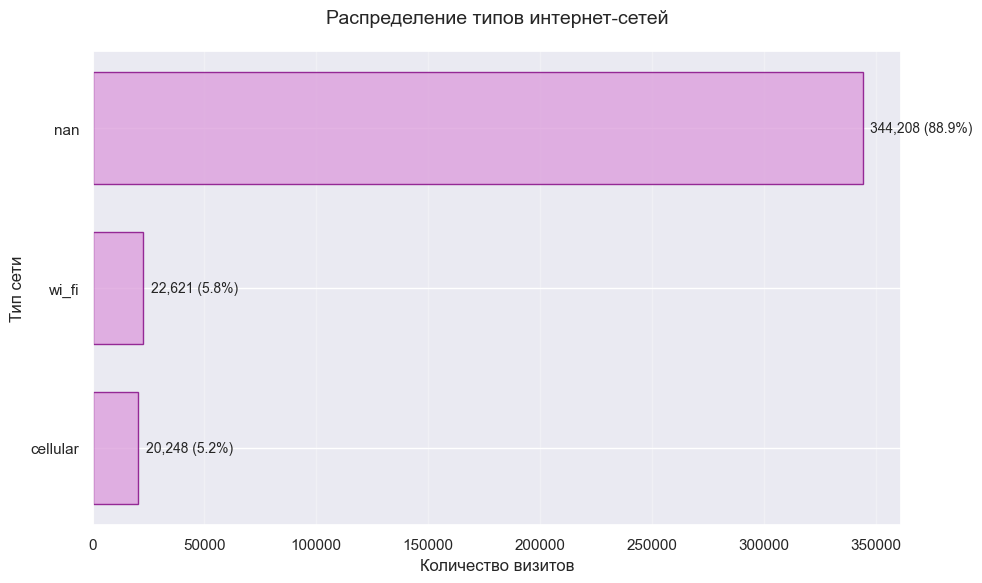

In [18]:
print("Самые популярные типы сетей (фильтрация)")
network_types = ["nan", "wi_fi", "cellular"]
data = data[data["networkType"].isin(network_types)]

network_counts = (
    data.groupby(by="networkType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(network_counts)), network_counts.values,
                color='plum', edgecolor='purple', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Тип сети", fontsize=12)
plt.title("Распределение типов интернет-сетей", fontsize=14, pad=20)
plt.yticks(range(len(network_counts)), network_counts.index)
plt.grid(axis='x', alpha=0.3)

total_visits = len(data)
for i, (network, count) in enumerate(network_counts.items()):
    percentage = (count / total_visits) * 100
    plt.text(count + max(network_counts.values)*0.01, i,
             f'{int(count):,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Тип точки входа на сайт

Типы сайтов


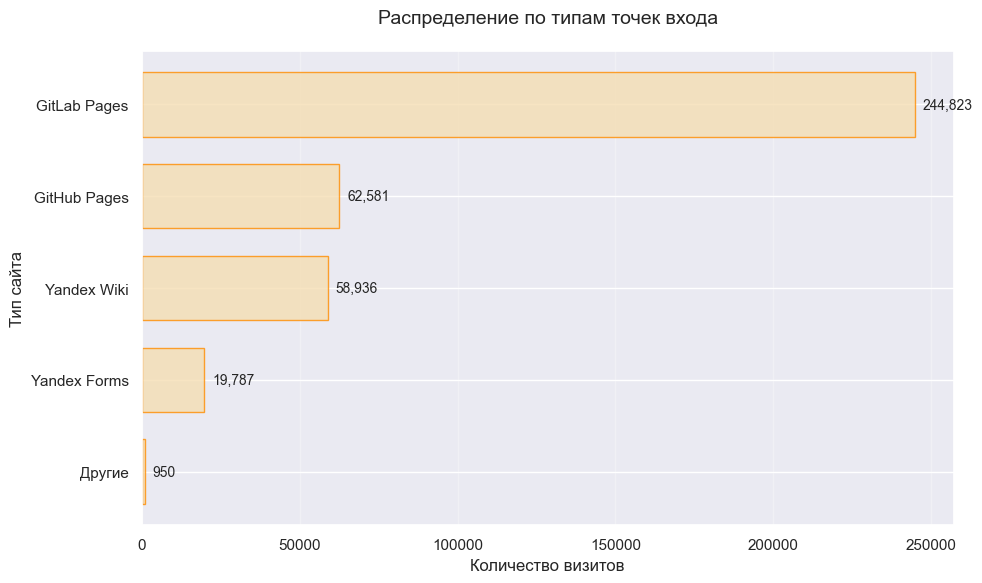

In [19]:
site_types = []
data["startURL"] = data["startURL"].astype(str)

for i in range(len(data)):
    if "github.io" in data["startURL"].iloc[i]:
        site_types.append(0)
    elif "gitlab.io" in data["startURL"].iloc[i]:
        site_types.append(1)
    elif "wiki.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(2)
    elif "forms.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(3)
    else:
        site_types.append(4)

data["siteType"] = site_types

print("Типы сайтов")
site_type_counts = (
    data.groupby(by="siteType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

site_type_labels = {
    0: "GitHub Pages",
    1: "GitLab Pages", 
    2: "Yandex Wiki",
    3: "Yandex Forms",
    4: "Другие"
}

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(site_type_counts)), site_type_counts.values,
                color='wheat', edgecolor='darkorange', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Тип сайта", fontsize=12)
plt.title("Распределение по типам точек входа", fontsize=14, pad=20)
plt.yticks(range(len(site_type_counts)), [site_type_labels[i] for i in site_type_counts.index])
plt.grid(axis='x', alpha=0.3)

for i, (site_type, count) in enumerate(site_type_counts.items()):
    plt.text(count + max(site_type_counts.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [20]:
data = data[data["siteType"].isin([0, 1])]

## 2. Дизайн теста

В апреле команда образовательного портала Teach-in.ru планирует провести A/B тест продолжительностью 4 недели, в рамках которого будет изменен дизайн главной страницы: добавлены интерактивные элементы навигации, улучшена визуальная структура разделов и оптимизирован процесс выбора образовательных программ. 

*Гипотеза — средняя по посетителям глубина просмотра страниц вырастет на 5%.*

Вам, как аналитику, предстоит задизайнить этот эксперимент.

Выберите размеры групп на основе некоторых соображений.

----

Посмотрим на кол-во уникальных пользователей в каждом из месяцев.

In [23]:
data_cnt = (
    data.groupby(["year", "month"]).agg({"clientID": pd.Series.nunique}).reset_index()
)
data_cnt["date_month"] = data_cnt.apply(
    lambda row: pd.to_datetime(f"""{row['year']}-{row['month']}-01"""), axis=1
)
data_cnt.set_index("date_month", inplace=True)
data_cnt

,year,month,clientID
date_month,,,
2021-01-01,2021,1,349
2021-02-01,2021,2,850
2021-03-01,2021,3,1060
2021-04-01,2021,4,744
2021-05-01,2021,5,823
2021-06-01,2021,6,432
2021-07-01,2021,7,240
2021-08-01,2021,8,293
2021-09-01,2021,9,581


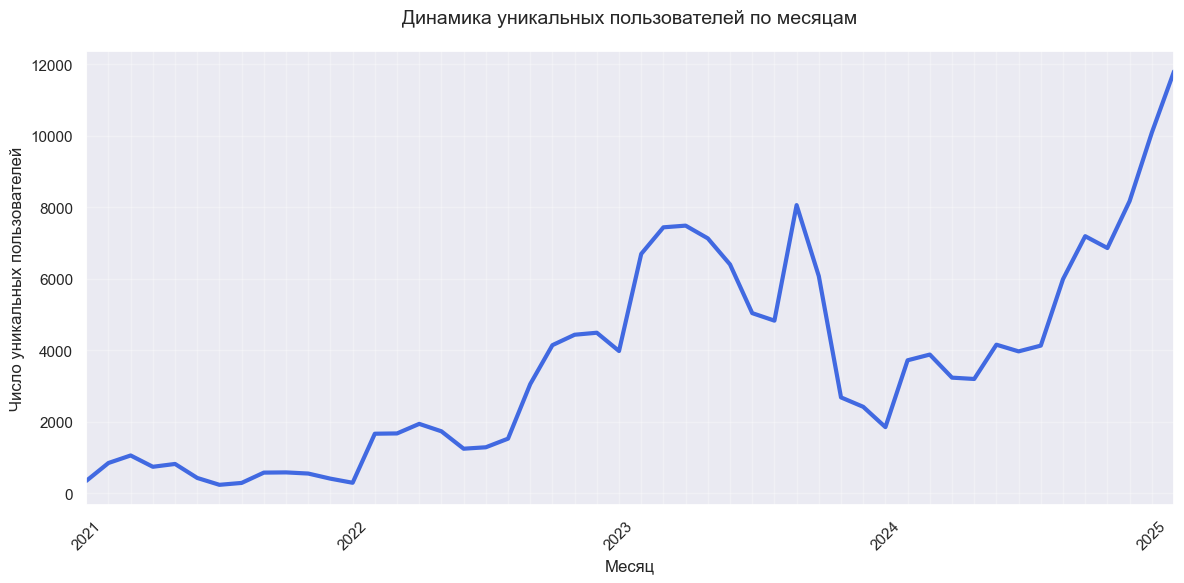

In [24]:
plt.figure(figsize=(12, 6))
data_cnt["clientID"].plot(lw=3, color='royalblue')
plt.ylabel("Число уникальных пользователей", fontsize=12)
plt.xlabel("Месяц", fontsize=12)
plt.title("Динамика уникальных пользователей по месяцам", fontsize=14, pad=20)
plt.grid(True, alpha=0.3)

# Автоматическое определение диапазона дат для xticks
start_date = data_cnt.index.min()
end_date = data_cnt.index.max()
plt.xticks(pd.date_range(start=start_date, end=end_date, freq='M'), rotation=45)

plt.tight_layout()
plt.show()

Количество визитов по посетителям

In [25]:
data.groupby(by="clientID")["visitID"].count().sort_values(ascending=False)

clientID
159631106194964144      525
1571345203385962128     379
1686212478710418142     286
167534681728506132      272
16456430291034906449    256
                       ... 
1663096176798996023       1
1663096086600001333       1
1663095790985142801       1
1663095629957884590       1
16910522111058091140      1
Name: visitID, Length: 152605, dtype: int64

Динамика целевой метрики

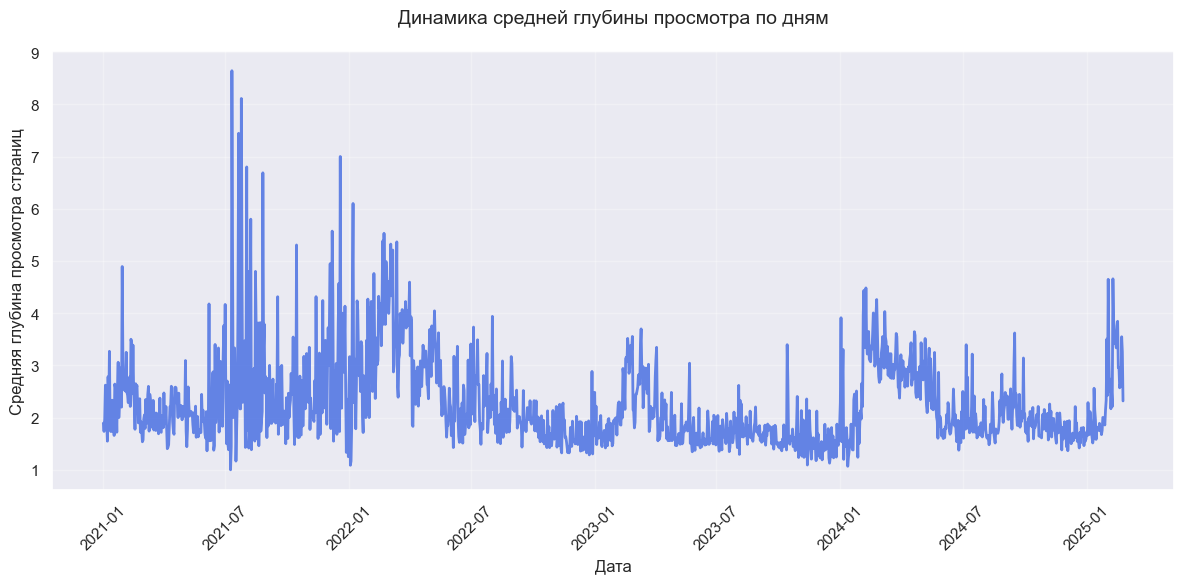

In [26]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 6))
    
    daily_pageviews = data.groupby(by="date")["pageViews"].mean()
    plt.plot(daily_pageviews.index, daily_pageviews.values, 
             linewidth=2, color='royalblue', alpha=0.8)
    
    plt.ylabel("Средняя глубина просмотра страниц", fontsize=12)
    plt.xlabel("Дата", fontsize=12)
    plt.title("Динамика средней глубины просмотра по дням", fontsize=14, pad=20)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Анализ динамики пользовательской активности

Наблюдается устойчивый рост количества уникальных пользователей платформы с течением времени. Данные демонстрируют выраженную сезонную составляющую:

- **Пиковые периоды активности:** февраль-март и сентябрь-октябрь
- **Сезонный спад:** апрель характеризуется снижением пользовательской активности по сравнению с весенним пиком

### Оценка минимального размера выборки

Для консервативной оценки принимаем, что в течение апреля платформу посетит **не менее 8,000 уникальных пользователей**. Эта оценка основана на анализе исторических данных и учитывает сезонные колебания трафика.

## Анализ мощности A/B теста

### Бизнес-ограничения и параметры теста
Предположим, что у нас стоит строгое бизнес-ограничение — определить наличие эффекта в течение одного месяца. В таком случае мы не можем проводить тест дольше, поэтому фиксируем его длительность.

**Параметры эксперимента:**
- Длительность теста: **T = 28 дней** (для соблюдения недельной и месячной периодичности)
- Размер тестовой и контрольной групп: **10,000 уникальных пользователей**
- Распределение: **50% в тест, 50% в контроль**
- Целевая метрика: **глубина просмотра (pageViews)**

### Методология оценки мощности
Построим график мощности для определения минимального детектируемого эффекта. На заданной мощности 0.8 мы сможем оценить, какие изменения метрики можем статистически значимо зафиксировать.

*Примечание:* При текущих ограничениях возможно, что 5% изменение не будет детектироваться на требуемой мощности.

In [27]:
test_control_size = 10_000  # пользователей в тесте+контроле
fraq_test = 0.5  # доля пользователей в тесте

# зададим промежуток времени, на котором валидируем
date_valid_start = pd.to_datetime("2025-01-01")
date_valid_end = pd.to_datetime("2025-02-28")
# зададим длительность теста
test_dlit = 28
# целевая метрика
target_column = "pageViews"

# размеры эффектов для оценки мощности
effects_list = np.linspace(0, 0.15, 16)

n_iter = 1_000  # количество итераций валидации
alpha = 0.05  # уровень значимости
n_jobs = 4  # количество параллельных потоков

## Валидация статистических критериев на исторических данных

---

### Методология валидации абсолютного и относительного t-test

Проведем комплексную валидацию статистических критериев на исторических данных с соблюдением временных границ доступного периода. На основе предыдущего анализа данных ограничим исторический период для обеспечения репрезентативности выборок.

#### Поэтапный алгоритм валидации

**Этап 1: Валидация корректности критериев (A/A тесты)**

a. Процедура многократного тестирования:
1. **Случайный выбор даты начала** - равномерное распределение в пределах доступного периода
2. **Формирование выборки** - отбор следующих 10,000 уникальных пользователей после выбранной даты
3. **Рандомизация групп** - случайное распределение пользователей на тестовую и контрольную группы (50/50)
4. **Применение критерия** - расчет p-value с использованием тестируемого критерия

b. Статистическая оценка:
- Расчет частоты отвержения нулевой гипотезы
- Построение доверительного интервала для вероятности ошибки I рода
- **Критерий корректности:** теоретический уровень значимости α = 0.05 должен попадать в доверительный интервал

**Этап 2: Оценка мощности критериев (A/B тесты с искусственным эффектом)**

a. Процедура для каждого размера эффекта:
1. **Случайный выбор даты начала** - аналогично этапу 1
2. **Формирование выборки** - отбор 10,000 уникальных пользователей
3. **Рандомизация групп** - случайное распределение (50% тест, 50% контроль)
4. **Введение эффекта** - умножение значений метрики в тестовой группе на (1 + effect)
5. **Статистический тест** - применение критерия к модифицированным данным

b. Анализ мощности:
- Расчет мощности как доли отвержений нулевой гипотезы
- Построение доверительных интервалов для оценки мощности
- Определение MDE (Minimum Detectable Effect) для мощности 80%

#### Ограничения и допущения

- **Временные границы:** тестовые периоды не выходят за пределы доступных исторических данных
- **Размер выборки:** 10,000 пользователей обеспечивает достаточную мощность для детектирования разумных эффектов
- **Сезонность:** случайный выбор дат минимизирует влияние сезонных факторов
- **Эффект вмешательства:** искусственное добавление эффекта имитирует реальное воздействие

Напишем абсолютный t-test.

In [31]:
def absolute_ttest(x, y):
    """
    Абсолютный t-test.

    Аргументы:
    x, y -- выборки одинакового размера
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """
    res = sps.ttest_ind(x, y)
    stat, pvalue = res.statistic, res.pvalue
    left_bound, right_bound = res.confidence_interval()

    return stat, pvalue, left_bound, right_bound

In [32]:
def relative_ttest(x, y, alpha=0.05):
    """
    Относительный t-test.

    Аргументы:
    x, y -- выборки одинакового размера
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """

    n = len(x)
    x_mean = x.mean()
    y_mean = y.mean()

    stat = x_mean / y_mean - 1
    var = x.var() / (y_mean**2) + y.var() * (x_mean**2) / (y_mean**4)
    std = np.sqrt(var)

    z_stat = np.sqrt(n) * stat / std
    pvalue = 2 * sps.norm.sf(np.abs(z_stat))

    q = sps.norm.ppf(1 - alpha / 2)
    left_bound = stat - q * std / np.sqrt(n)
    right_bound = stat + q * std / np.sqrt(n)

    return stat, pvalue, left_bound, right_bound

In [33]:
def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(n_rejects, n_iter, method="wilson")

    return prob_reject, left_bound, right_bound


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(12, 4),
    title=None,
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теор вероятность ошибки первого рода
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    if show_pvals:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Гистограмма p-value
        ax1.hist(
            pvals,
            bins=np.linspace(0, 1, 21),
            alpha=0.7,
            color='lightblue',
            edgecolor='navy',
            weights=np.ones(len(pvals)) / len(pvals),
        )
        ax1.set_xlabel("p-value", fontsize=11)
        ax1.set_ylabel("Доля экспериментов", fontsize=11)
        ax1.set_title("Распределение p-value", fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Переключаемся на второй subplot
        plt.sca(ax2)
    else:
        plt.figure(figsize=figsize)

    # Отрисовка интервала для вероятности отвержения критерия
    plt.hlines(0, 0, 1, color="gray", lw=3, alpha=0.8)
    plt.vlines(alpha, -0.2, 0.2, color="red", lw=4, linestyle="--", alpha=0.8, label=f'α = {alpha}')
    plt.fill_between(
        [left_bound, right_bound], [0.12] * 2, [-0.12] * 2, 
        color="lightgreen", alpha=0.5, label='Доверительный интервал'
    )
    plt.scatter(prob_reject, 0, s=200, marker="D", color="darkred", edgecolor='black', label='Точечная оценка')
    
    plt.xlim((min(alpha, left_bound) - 0.02, max(alpha, right_bound) + 0.02))
    plt.title(
        f"Вероятность отвержения H₀\n"
        f"{100*prob_reject:.2f}% [{100*left_bound:.2f}%, {100*right_bound:.2f}%]",
        fontsize=12
    )
    if title:
        plt.suptitle(title, fontsize=14, y=1.02)
    
    plt.ylim((-0.3, 0.3))
    plt.yticks([])
    plt.xlabel("Вероятность отвержения", fontsize=11)
    plt.legend(loc='upper right', frameon=True)
    plt.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="График мощности критерия",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 5))

    plt.plot(effects_list, powers, label=label, lw=3, marker='s', markersize=6)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.2)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="red",
            linestyle='--',
            alpha=0.7,
            label="Мощность 0.8",
            lw=2
        )
        plt.xlabel("Размер относительного эффекта", fontsize=12)
        plt.ylabel("Мощность критерия", fontsize=12)
        plt.title(title, fontsize=14, pad=15)
        
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)

In [34]:
def add_effect(x, effect, target_name="pilot", relative_effect=True):
    """
    Функция искусственного добавления эффекта в тестовую выборку

    Аргументы:
    x -- выборка
    effect -- добавляемый эффект

    Возвращает:
    x -- выборка с добавленным эффектом
    """

    x_copy = x.copy()
    if relative_effect:
        x_copy[target_name] *= 1 + effect
    else:
        x_copy[target_name] += effect

    return x_copy


def run_1_iteration(
    test,
    generate_samples,
    target_name,
    add_effect,
    effects_list=[0],
    relative_effect=True,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    add_effect -- функция добавления эффекта
    effects_list --  массив размеров добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным

    Возвращает: pvalue
    """
    # Генерируем выборки
    x_data, y_data = generate_samples(data=data)

    pvals = []
    for effect in effects_list:
        # Добавляем эффект, если хотим оценить мощность
        x_data_cp = add_effect(
            x_data, effect, target_name=target_name, relative_effect=relative_effect
        )
        # Применяем критерий
        pvals.append(test(x_data_cp, y_data)[1])
    return pvals


def run_experiments(
    test,
    generate_samples,
    data=None,
    add_effect=add_effect,
    n_iter=10000,
    sample_size=1000,
    effect=0,
    relative_effect=True,
    n_jobs=4,
    alpha=0.05,
    target_name="pilot",
    draw=False,
    title=None,
    show_pvals=True,
):
    """
    Проведение серии AA-тестов на исторических данных.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    data -- исторические данные
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """

    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test, generate_samples, target_name, add_effect, [effect], relative_effect
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    pvals = np.array(pvals).flatten()
    # Подсчет числа отвержений
    n_rejects = (pvals < alpha).sum()

    # Оценка вероятности отвержения
    prob_reject, left_bound, right_bound = estimate_reject_prob(n_rejects, n_iter)

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            prob_reject,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
            title,
        )

    return prob_reject, (left_bound, right_bound)


def estimate_power(
    test,
    generate_samples,
    data=None,
    n_jobs=4,
    n_iter=10000,
    sample_size=1000,
    effects_list=np.linspace(0, 0.1, 11),
    relative_effect=True,
    alpha=0.05,
    target_name="pilot",
):
    """
    Проведение серии AA-тестов на исторических данных с добавением разных эффектов.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    data -- исторические данные
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """
    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test,
            generate_samples,
            target_name,
            add_effect,
            effects_list,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )

    # Подсчет числа отвержений
    n_rejects = (np.array(pvals) < alpha).sum(axis=0)

    # Оценка мощности
    powers, left_bounds, right_bounds = estimate_reject_prob(n_rejects, n_iter)

    return powers, left_bounds, right_bounds

Напишем функцию, отбирающую исторические данные и делящую выборку на тест и контроль.

In [35]:
def generate_subarray(
    data,
    date_valid_start=date_valid_start,
    date_valid_end=date_valid_end,
    test_dlit=test_dlit,
    test_control_size=test_control_size,
    fraq_test=fraq_test,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Генерация выборок 2-x групп посредством случайного деления пользователей на 2 группы
    Агрегация данных по пользователям

    Аргументы:
    data -- данные
    date_valid_start, date_valid_end -- временные границы валидации
    test_dlit -- длительность истории, которую берем в тест
    test_control_size -- размер теста+контроля
    fraq_test -- доля тестовой группы

    Возвращает:
    test_groupped, control_groupped -- сгруппированные данные по тесту и контролю
    """
    # определяем временные границы теста
    all_days = (date_valid_end - date_valid_start).days - test_dlit
    diff_from_start = np.random.choice(all_days, 1)[0]
    start_date = date_valid_start + pd.to_timedelta(diff_from_start, "D")
    end_date = start_date + pd.to_timedelta(test_dlit, "D")

    # берем нужный срез данных по времени
    data_start_end = data[
        (data[date_column] >= start_date) & (data[date_column] < end_date)
    ]

    # из всех пользователей выбираем тест и контроль
    users = data_start_end[user_column].unique()
    test_size = int(test_control_size * fraq_test)
    control_size = test_control_size - test_size
    test_users = np.random.choice(users, test_size, replace=False)
    other_users = list(set(users) - set(test_users))
    control_users = np.random.choice(
        other_users, min(control_size, len(other_users)), replace=False
    )

    # берем нужный срез данных по пользователям
    test = data_start_end[data_start_end[user_column].isin(test_users)]
    control = data_start_end[data_start_end[user_column].isin(control_users)]

    # агрегируем результат
    agg_dict = {target_column: "mean"}
    test_groupped = test.groupby(user_column).agg(agg_dict)
    control_groupped = control.groupby(user_column).agg(agg_dict)

    return test_groupped, control_groupped

### 2.1. Проверка абсолютного и относительного теста на корректность и оценка их мощности

Корректность

Абсолютный


  0%|          | 0/1000 [00:00<?, ?it/s]

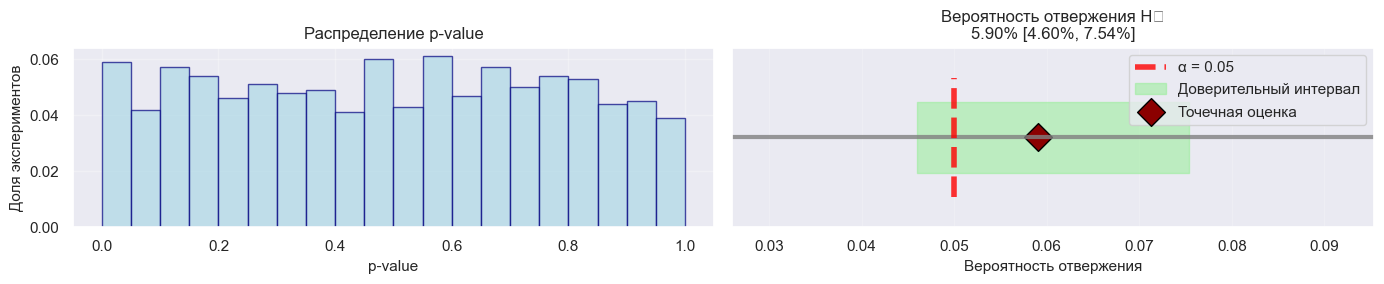

Относительный


  0%|          | 0/1000 [00:00<?, ?it/s]

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 759, in process_result_item
    executor._adjust_process_count()
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 1209, in _adjust_process_count
    p.start()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 121, in start
    self._popen = self._Popen(self)


KeyboardInterrupt: 

In [36]:
tests = [
    lambda x, y: absolute_ttest(x[target_column], y[target_column]),
    lambda x, y: relative_ttest(x[target_column], y[target_column]),
]
names = ["Абсолютный", "Относительный"]

for test, name in zip(tests, names):
    print(name)
    run_experiments(
        test=lambda x, y: absolute_ttest(x[target_column], y[target_column]),
        generate_samples=generate_subarray,
        target_name=target_column,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        show_pvals=True,
        draw=True,
        n_jobs=n_jobs,
    );

Мощность

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

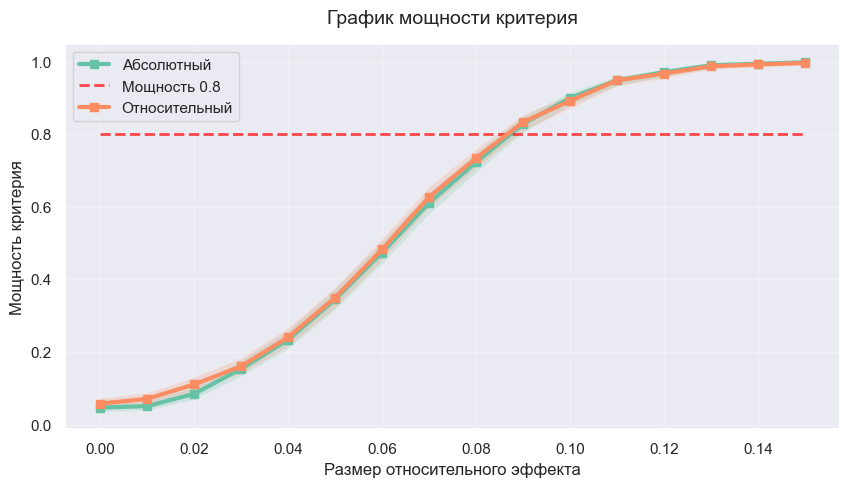

In [37]:
tests = [
    lambda x, y: absolute_ttest(x[target_column], y[target_column]),
    lambda x, y: relative_ttest(x[target_column], y[target_column]),
]
names = ["Абсолютный", "Относительный"]

for i, (test, name) in enumerate(zip(tests, names)):
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples=generate_subarray,
        target_name=target_column,
        effects_list=effects_list,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        n_jobs=n_jobs,
    )
    draw_power(
        powers,
        left_bounds,
        right_bounds,
        effects_list=effects_list,
        label=name,
        new_figure=(i == 0),
    )

**Вывод:** тесты работают корректно. Абсолютный тест имеет почти достигает достаточной мощности при эффекте в 10%.

### 2.2 Проверка регрессионных тестов из задания на корректность и подсчет их мощности

---

Провалидируйте и сравните следующие подходы к уменьшению дисперсии.
1. Стратификация по операционной системе. Редко встречающиеся операционные системы можно исключить или же объединить с какой-то другой стратой.
2. CUPED со стандартной ковариатой &mdash; значение исследуемой метрики для пользователя/бакета на предэкспериментальном периоде. Однако, в этом случае у нас нет соответствующих значений для новых пользователей. В таком случае можно сделать новый категориальный признак &mdash; имеется ли у пользователя активность во время предэкспериментального периода. Для тех, у кого не было активности, значение ковариаты можно заменить на константу. Далее использовать CUPED со стратификацией по дополнительному категориальному признаку.
3. Комбинация вариантов 1 и 2.
4. Рассмотрите также добавление других ковариат в методе CUPED.
5. CUPED, с прогнозом ML-модели в качестве ковариаты, предсказывающей целевую метрику на основе имеющихся признаков.

Во всех случаях можно использовать любые реализации методов понижения дисперсии, в том числе через линейную регрессию.


---

Реализуем функцию генерации данных с подсчетом стратификационных данных и ковариат (в том числе — и предсказанных).

In [36]:
# вещественные признаки для построения моделей
real_features = [
    "prepilot",
    "windowClientWidth",
    "windowClientHeight",
]

# категориальные признаки для построения моделей
cat_features = [
    "has_prepilot",
    "operatingSystemRoot",
    "browser",
    "regionCountry",
    "screenOrientation",
    "networkType",
]


def generate_subarray_covariates(
    data,
    agg_dict,
    date_valid_start=date_valid_start,
    date_valid_end=date_valid_end,
    test_dlit=test_dlit,
    test_control_size=test_control_size,
    fraq_test=fraq_test,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
    real_features=real_features,
    cat_features=cat_features,
    model=CatBoostRegressor(n_estimators=100, cat_features=cat_features, verbose=False),
    cuped=False,
    cupac=False,
):
    """
    Генерация выборок 2-x групп посредством случайного деления пользователей на 2 равные группы
    Агрегация данных по пользователям

    Аргументы:
    data -- данные
    date_valid_start, date_valid_end -- временные границы валидации
    test_dlit -- длительность истории, которую берем в тест
    test_control_size -- размер теста+контроля
    fraq_test -- доля тестовой группы
    cuped -- будет ли cuped
    cupac -- будет ли cupac

    Возвращает:
    test_groupped, control_groupped -- сгруппированные данные по тесту и контролю
    """

    # определяем временные границы теста
    all_days = (date_valid_end - date_valid_start).days - test_dlit
    diff_from_start = np.random.choice(all_days, 1)[0]
    start_date = date_valid_start + pd.to_timedelta(diff_from_start, "D")
    end_date = start_date + pd.to_timedelta(test_dlit, "D")

    # берем нужный срез данных по времени
    data_start_end = data[
        (data[date_column] >= start_date) & (data[date_column] < end_date)
    ]

    # из всех пользователей выбираем тест и контроль
    users = data_start_end[user_column].unique()
    test_size = int(test_control_size * fraq_test)
    control_size = test_control_size - test_size
    test_users = np.random.choice(users, test_size, replace=False)
    other_users = list(set(users) - set(test_users))
    control_users = np.random.choice(
        other_users, min(control_size, len(other_users)), replace=False
    )

    # берем нужный срез данных по пользователям
    test = data_start_end[data_start_end[user_column].isin(test_users)]
    control = data_start_end[data_start_end[user_column].isin(control_users)]

    # агрегируем данные
    test_groupped = test.groupby(user_column).agg(agg_dict)
    control_groupped = control.groupby(user_column).agg(agg_dict)

    # возвращаем данные в нужном виде
    if cuped:
        test_groupped = count_prepilot_metric(
            data,
            test_groupped,
            start_date,
            test_dlit=test_dlit,
            date_column=date_column,
            user_column=user_column,
            target_column=target_column,
        )
        control_groupped = count_prepilot_metric(
            data,
            control_groupped,
            start_date,
            test_dlit=test_dlit,
            date_column=date_column,
            user_column=user_column,
            target_column=target_column,
        )

        return test_groupped, control_groupped
    if cupac:
        return count_cupac_metric(
            data,
            agg_dict,
            test_groupped,
            control_groupped,
            start_date,
            test_dlit=test_dlit,
            date_column=date_column,
            user_column=user_column,
            target_column=target_column,
            real_features=real_features,
            cat_features=cat_features,
            model=model,
        )
    return test_groupped, control_groupped

Функция подсчета метрики на препилоте

In [37]:
def count_prepilot_metric(
    data,
    group,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Считаем метрику на препилоте

    Аргументы:
    data -- данные
    group -- сгруппированные данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    group -- сгруппированные данные c метрикой на препилоте
    """

    # берем нужный срез по датам
    prepilot_start_date = start_date - pd.to_timedelta(test_dlit, "D")
    prepilot_end_date = start_date - pd.to_timedelta(1, "D")

    prepilot = data[
        (data[date_column] >= prepilot_start_date)
        & (data[date_column] < prepilot_end_date)
    ]

    # берем нужный срез по пользователям
    users = group.index.unique()
    prepilot_group = prepilot[prepilot[user_column].isin(users)]

    # группируем данные
    prepilot_groupped = prepilot_group.groupby(user_column)[[target_column]].mean()

    # заполняем данными препилота
    group["prepilot"] = prepilot_groupped[target_column]
    group["has_prepilot"] = group["prepilot"].apply(lambda x: 0 if pd.isnull(x) else 1)
    group["prepilot"].fillna(0, inplace=True)

    return group

Сбор данных для трейна модели предсказания для CUPAC

In [38]:
def collect_train_for_cupac(
    data,
    agg_dict,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Собираем данные трейна для метода СUPAC

    Аргументы:
    data -- данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    prepilot_groupped -- сгруппированные данные препилота для обучения СUPAC
    """
    # берем нужный срез препилота по времени
    prepilot_start_date = start_date - pd.to_timedelta(test_dlit, "D")
    prepilot_end_date = start_date - pd.to_timedelta(1, "D")
    prepilot = data[
        (data[date_column] >= prepilot_start_date)
        & (data[date_column] < prepilot_end_date)
    ]

    # агрегируем данные
    prepilot_groupped = prepilot.groupby(user_column).agg(agg_dict)
    # добавляем данные препилота
    prepilot_groupped = count_prepilot_metric(
        data,
        prepilot_groupped,
        prepilot_start_date,
        test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )
    return prepilot_groupped

Функция подсчета предсказания, чтобы использовать CUPAC

In [39]:
def count_cupac_metric(
    data,
    agg_dict,
    test_groupped,
    control_groupped,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
    real_features=real_features,
    cat_features=cat_features,
    model=CatBoostRegressor(n_estimators=200, cat_features=cat_features, verbose=False),
):
    """
    Считаем CUPAC-метрику

    Аргументы:
    data -- данные
    test_groupped, control_groupped -- сгруппированные данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    test_groupped, control_groupped -- сгруппированные данные c метрикой на препилоте
    """
    # добавляем метрики препилота в тест и контроль
    test_groupped = count_prepilot_metric(
        data,
        test_groupped,
        start_date,
        test_dlit=test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )
    control_groupped = count_prepilot_metric(
        data,
        control_groupped,
        start_date,
        test_dlit=test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )
    # создаем трейн для модели
    train = collect_train_for_cupac(
        data,
        agg_dict,
        start_date,
        test_dlit=test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )

    # фичи для модели
    features = real_features + cat_features

    # обучаем модель на трейне
    model.fit(train[features], train[target_column])

    test_groupped["model_predicted"] = model.predict(test_groupped[features])
    control_groupped["model_predicted"] = model.predict(control_groupped[features])

    return test_groupped, control_groupped

Регрессионный t-test. Есть возможность сделать стратификацию, CUPED и CUPAC по нескольким колонкам

In [40]:
def regression_ttest(
    x_data,
    y_data,
    cuped=False,
    stratified=False,
    sample_name="pilot",
    treatment_name="treatment",
    covariate_names=[],
    strat_names=[],
):
    """
    T-test с CUPED/без CUPED, со стратификацией/без реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param stratified: применять ли стратификацию
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат
    :param strat_names: массив имен стратификационных столбцов

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """

    x_data_cp = x_data.copy()
    y_data_cp = y_data.copy()

    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])
    # удаляем ненужные столбцы из датасета
    if not cuped:
        covariate_names = []
    if not stratified:
        strat_names = []
    data = data[
        [treatment_name] + list(covariate_names) + list(strat_names) + [sample_name]
    ]

    # делаем стратификацию по нужным фичам
    data = pd.get_dummies(data, columns=strat_names)

    # определяем имена фичей, на которых будем обучать модель
    feature_names = list(set(data.columns) - set([sample_name]))

    # обучаем модель
    model = ols(f"{sample_name} ~ " + "+".join(feature_names), data=data).fit()
    # забираем таблицу с результатами
    summary = model.summary2().tables[1]
    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, "t"]
    pvalue = summary.loc[treatment_name, "P>|t|"]
    left_bound = summary.loc[treatment_name, "[0.025"]
    right_bound = summary.loc[treatment_name, "0.975]"]
    return stat, pvalue, left_bound, right_bound

Проведение валидации

Простой t-test


  0%|          | 0/1000 [00:00<?, ?it/s]

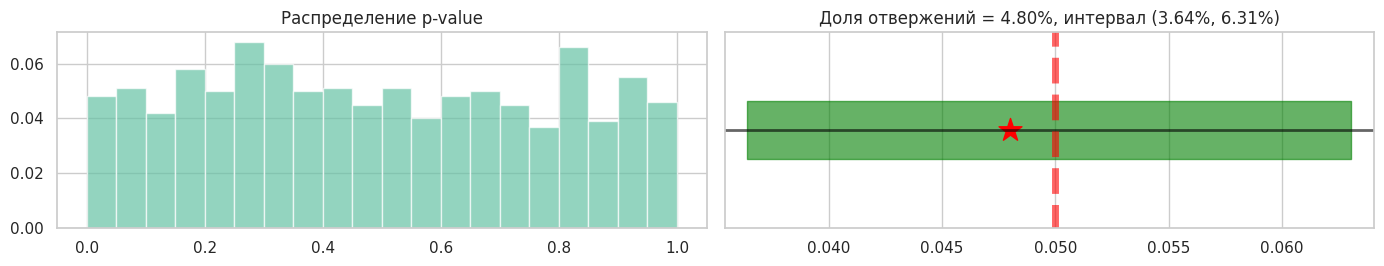

Cтрат по ОС


  0%|          | 0/1000 [00:00<?, ?it/s]

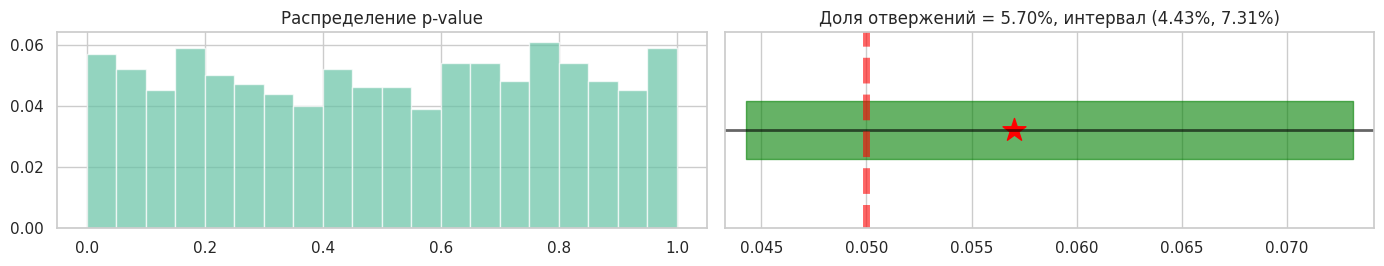

CUPED по препилоту


  0%|          | 0/1000 [00:00<?, ?it/s]

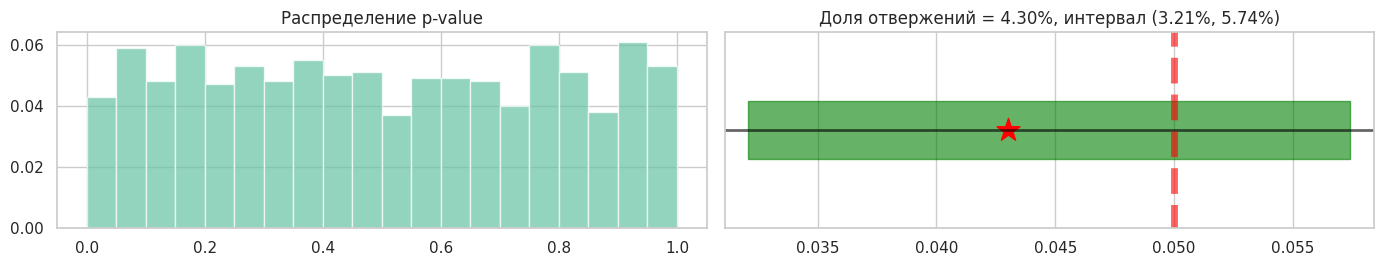

CUPED по нескольким ковариатам


  0%|          | 0/1000 [00:00<?, ?it/s]

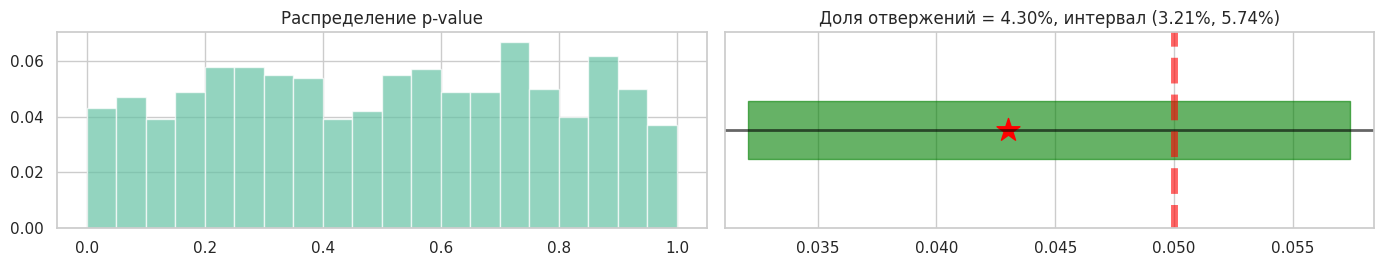

СUPAC: CatBoostRegressor


  0%|          | 0/1000 [00:00<?, ?it/s]

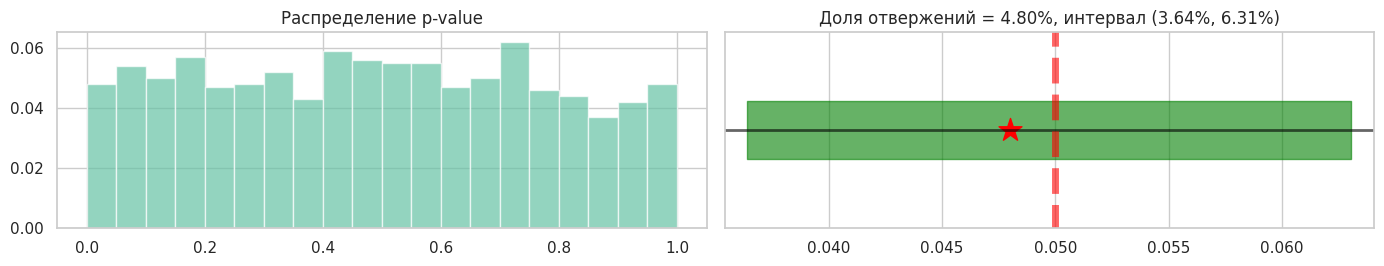

In [41]:
agg_dict = {
    "pageViews": "mean",
    "operatingSystemRoot": lambda x: x.iloc[0],
    "browser": lambda x: x.iloc[0],
    "regionCountry": lambda x: x.iloc[0],
    "screenOrientation": lambda x: x.iloc[0],
    "networkType": lambda x: x.iloc[0],
    "siteType": lambda x: x.iloc[0],
    "windowClientWidth": "mean",
    "windowClientHeight": "mean",
}

tests = [
    lambda x, y: regression_ttest(
        x, y, cuped=False, stratified=False, sample_name=target_column
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=False,
        stratified=True,
        strat_names=["operatingSystemRoot"],
        sample_name=target_column,
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=True,
        stratified=True,
        covariate_names=["prepilot"],
        strat_names=["has_prepilot"],
        sample_name=target_column,
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=True,
        stratified=True,
        covariate_names=["prepilot", "windowClientWidth", "windowClientHeight"],
        strat_names=[
            "has_prepilot",
            "operatingSystemRoot",
            "browser",
            "regionCountry",
            "screenOrientation",
            "networkType",
            "siteType",
        ],
        sample_name=target_column,
    ),
    lambda x, y: regression_ttest(
        x, y, cuped=True, covariate_names=["model_predicted"], sample_name=target_column
    ),
]

generate_samples_list = [
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict),
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict),
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict, cuped=True),
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict, cuped=True),
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict, cupac=True),
]
names = [
    "Простой t-test",
    "Cтрат по ОС",
    "CUPED по препилоту",
    "CUPED по нескольким ковариатам",
    "СUPAC: CatBoostRegressor",
]

for test, generate_samples, name in zip(tests, generate_samples_list, names):
    print(name)
    run_experiments(
        test=test,
        generate_samples=generate_samples,
        target_name=target_column,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        show_pvals=True,
        draw=True,
        n_jobs=n_jobs,
    );

Простой t-test


  0%|          | 0/1000 [00:00<?, ?it/s]

Cтрат по ОС


  0%|          | 0/1000 [00:00<?, ?it/s]

CUPED по препилоту


  0%|          | 0/1000 [00:00<?, ?it/s]

CUPED по нескольким ковариатам


  0%|          | 0/1000 [00:00<?, ?it/s]

СUPAC: CatBoostRegressor


  0%|          | 0/1000 [00:00<?, ?it/s]

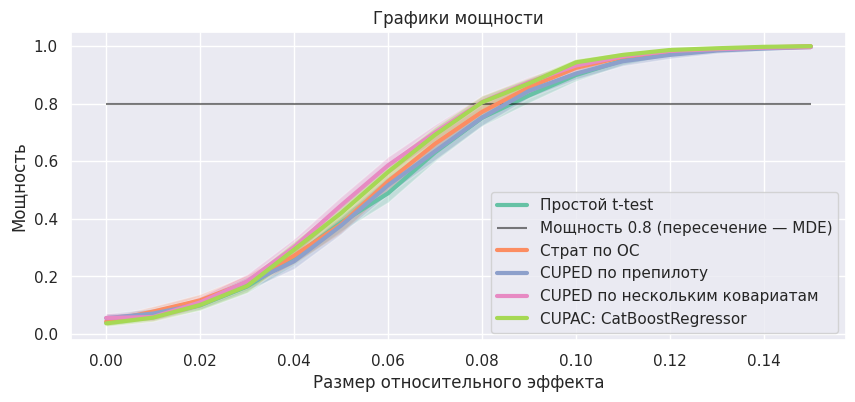

In [42]:
powers_list = []
left_bounds_list = []
right_bounds_list = []

for i, (test, generate_samples, name) in enumerate(
    zip(tests, generate_samples_list, names)
):
    print(name)
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples=generate_samples,
        target_name=target_column,
        effects_list=effects_list,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        n_jobs=n_jobs,
    )
    powers_list.append(powers)
    left_bounds_list.append(left_bounds)
    right_bounds_list.append(right_bounds)
    draw_power(
        powers,
        left_bounds,
        right_bounds,
        effects_list=effects_list,
        label=name,
        new_figure=(i == 0),
    )

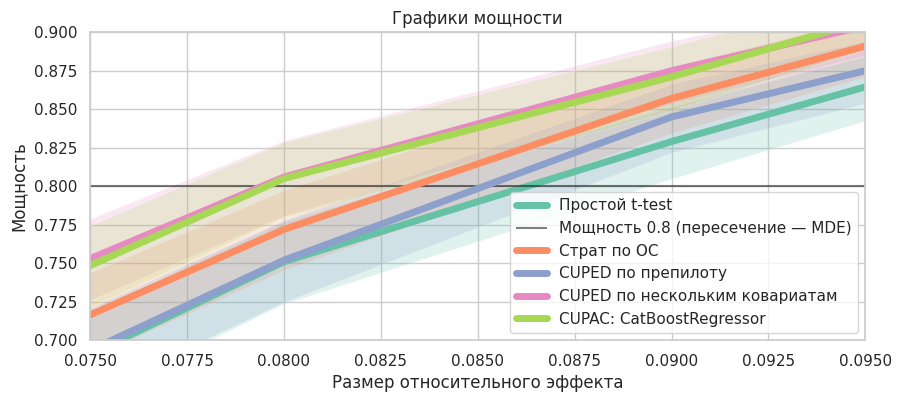

In [49]:
with sns.axes_style("whitegrid"):
    for i in range(len(tests)):
        draw_power(
            powers_list[i],
            left_bounds_list[i],
            right_bounds_list[i],
            effects_list=effects_list,
            label=names[i],
            new_figure=(i == 0),
        )
        plt.xlim((0.075, 0.095))
        plt.ylim((0.7, 0.9))

**Вывод:** мы проверили корректность и мощность абсолютного и относительного т-теста и проверили, как в данном случае работают методы уменьшения дисперсии. Они в данном случае помогли, но не сильно: MDE удалось уменьшить примерно на 0.7%.